## Persistence Images  + Clamped Ridge Regression

The purpose of this notebook is to show what the optimization does when we clamp the ridge regression regularization to different ranges


In [ ]:
import csv
import time
import pickle
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd

# hyperparameter optimization routines
from hyperopt import hp
from hyperopt import tpe
from hyperopt import fmin
from hyperopt import Trials
from hyperopt import STATUS_OK
from hyperopt.pyll.stochastic import sample

# persistence images routines
import PersistenceImages.persistence_images as pimgs

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os.path

from HyperoptUtils import *
from BoneData import *

In [ ]:
# -------------------
# Perform a Bayesian optimization search across persistence images
bone_df = get_bone_data_df()
dgm_df = bone_df[['dgm']]
target_df = bone_df['trabnum']
scorer = make_scorer(mean_squared_error)
max_evals = 200
cv=6


birth_range = (0, 0.5)
pers_range = (0, 0.61)
max_death = 0.7

pipeline_ridge = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())])


objective = lambda params: cv_objective(params,
                                        dgm_df=dgm_df,
                                        target_df=target_df, 
                                        scorer=scorer,
                                        cv=cv,
                                        verbose=True)

ranges = [-9, -6, -3, 0, 3, 6]
R = len(ranges)-1

all_bayes_trials = []
all_best = []
for i in range(R):
    print("alpha_range = ", [ranges[i:i+2]])
    param_space = {'estimator_params': 
                    {
                    'method': pipeline_ridge,
                    'kwargs':  {
                                'ridge__normalize':False,
                                'ridge__fit_intercept':True,
                                'ridge__alpha':hp.loguniform('alphas', ranges[i], ranges[i+1])
                                }
                    },
                    'dgm_vec_params':
                    {
                    'method': vec_dgm_by_per_images,
                    'kwargs': {
                                'birth_range': birth_range,
                                'pers_range': pers_range,
                                'max_death': max_death,
                                'pixel_size': hp.uniform('pixel_size', 0.01, 0.1),
                                'weight_params': {'n': 1},
                                'kernel_params': {'sigma': hp.uniform('sigma', 0.005, 0.1)},
                                'do_plot': False
                                }
                    }
                }

    bayes_trials = Trials()

    # run the hyperparamter optimization
    best = fmin(fn=objective, 
                space=param_space, 
                algo=tpe.suggest, 
                max_evals=max_evals, 
                trials=bayes_trials)
    all_bayes_trials.append(bayes_trials)
    all_best.append(best)

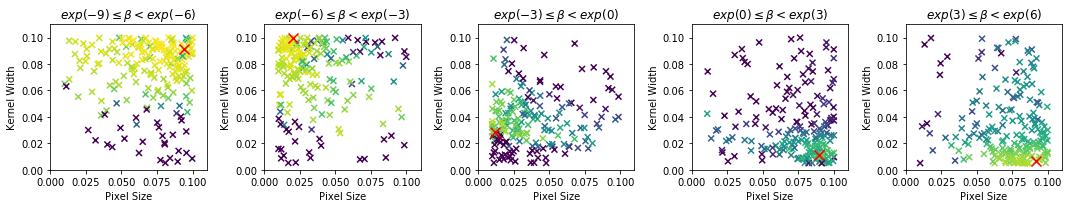

In [28]:
# -------------------
# Plot the results
vmin = np.inf
for r in range(R):
    for f in all_bayes_trials[r]:
        vmin = min(minval, f['result']['loss'])
vmax = 0.1

resol = 3
plt.figure(figsize=(resol*R, resol))
AllY = []
for r in range(R):
    N = len(all_bayes_trials[r])
    Y = np.zeros((N, 4))
    for i, f in enumerate(all_bayes_trials[r]):
        y = [f['result']['loss'], np.log10(f['result']['params']['estimator_params']['kwargs']['ridge__alpha'])]
        dparams = f['result']['params']['dgm_vec_params']['kwargs']
        y.append(dparams['pixel_size'])
        y.append(dparams['kernel_params']['sigma'])
        Y[i, :] = y
    AllY.append(Y)
    plt.subplot(1, R, r+1)
    plt.scatter(Y[:, 2], Y[:, 3], c=Y[:, 0], marker='x', vmin=vmin, vmax=vmax, cmap='viridis_r')
    idx = np.argmin(Y[:, 0])
    plt.scatter(Y[idx, 2], Y[idx, 3], 100, c='r', marker='x')
    plt.xlabel("Pixel Size")
    plt.ylabel("Kernel Width")
    plt.xlim([0, 0.11])
    plt.ylim([0, 0.11])
    plt.title("$exp(%i) \leq \\beta < exp(%i$)"%(ranges[r], ranges[r+1]))
plt.tight_layout()
plt.savefig("AlphaRanges.svg", bbox_inches='tight')
AllY = np.array(AllY)
sio.savemat("AlphaRanges.mat", {"AllY":AllY, "ranges":np.array(ranges)})